<a href="https://colab.research.google.com/github/adimyth/datascience_stuff/blob/master/nlp/JustEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Just Embeddings

Dataset - [Kaggle Cat-Dat-II Challenge](https://www.kaggle.com/c/cat-in-the-dat-ii)

Code - [Abhishek Thakur's Kernel | Kaggle](https://www.kaggle.com/c/cat-in-the-dat-ii)

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import joblib
import string
import pandas as pd
import numpy as np
import category_encoders as ce
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Dropout
from tensorflow.keras.layers import SpatialDropout1D, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [3]:
!cp drive/My\ Drive/Data/Cat-Dat-II/* .

In [ ]:
!unzip train.csv.zip
!unzip test.csv.zip
!unzip sample_submission.csv.zip

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [6]:
bin_cols = [col for col in train.columns if "bin" in col]
ord_cols = [col for col in train.columns if "ord" in col]
nom_cols = [col for col in train.columns if "nom" in col]
time_cols = ["day", "month"]

## Missing Values

In [7]:
def get_nans_volume(data):
    na = []
    feat = list(set(data.columns)-set(["id", "target"]))
    for col in feat:
        na.append(data[col].isna().sum())
    df = pd.DataFrame({"Columns": feat, "# NaNs": na})
    df["Percentage"] = (df["# NaNs"]*100/train.shape[0]).round(2)
    return df

In [8]:
df = get_nans_volume(train)

In [9]:
df.sort_values(by="Percentage", ascending=False)

,Columns,# NaNs,Percentage
9,ord_0,18288,3.05
21,nom_0,18252,3.04
13,nom_1,18156,3.03
17,nom_3,18121,3.02
5,nom_6,18131,3.02
0,nom_4,18035,3.01
19,nom_2,18035,3.01
14,ord_1,18041,3.01
1,ord_2,18075,3.01
11,bin_4,18047,3.01


In [10]:
print(f"Training Data Missing Value (mean %): {df['Percentage'].mean():.2f}")

Training Data Missing Value (mean %): 3.00


In [11]:
df = get_nans_volume(test)

In [12]:
df.sort_values(by="Percentage", ascending=False)

,Columns,# NaNs,Percentage
19,nom_2,12179,2.03
17,nom_3,12176,2.03
14,ord_1,12167,2.03
1,ord_2,12105,2.02
2,ord_5,12047,2.01
21,nom_0,12062,2.01
4,nom_9,12060,2.01
20,bin_1,12038,2.01
7,ord_3,12053,2.01
0,nom_4,11993,2.00


In [13]:
print(f"Test Data Missing Value (mean %): {df['Percentage'].mean():.2f}")

Test Data Missing Value (mean %): 2.00


## Target Distribution

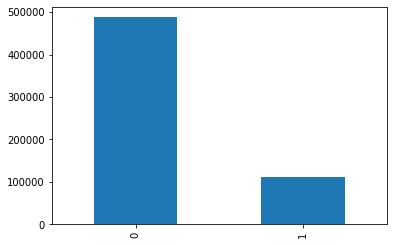

In [14]:
_ = train["target"].value_counts().plot(kind="bar")

In [15]:
print(f"Class0 (%): {(train[train['target']==0].shape[0]*100/train.shape[0]):.2f}")
print(f"Class1 (%): {(train[train['target']==1].shape[0]*100/train.shape[0]):.2f}")

Class0 (%): 81.28
Class1 (%): 18.72


## Binary Features

In [16]:
test["target"] = -1

In [17]:
df = pd.concat([train, test], sort=False)

In [18]:
train.shape, test.shape, df.shape

((600000, 25), (400000, 25), (1000000, 25))

In [19]:
df[bin_cols].head()

,bin_0,bin_1,bin_2,bin_3,bin_4
0,0.0,0.0,0.0,F,N
1,1.0,1.0,0.0,F,Y
2,0.0,1.0,0.0,F,N
3,NaN,0.0,0.0,F,N
4,0.0,NaN,0.0,T,N


In [20]:
df["bin_3"] = df["bin_3"].replace({"F":0, "T":1})
df["bin_4"] = df["bin_4"].replace({"N":0, "Y":1})

Replace nans by 3 for each of the binary column

In [21]:
for col in bin_cols:
    df[col] = df[col].fillna(3)

In [22]:
df[bin_cols].head()

,bin_0,bin_1,bin_2,bin_3,bin_4
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0
4,0.0,3.0,0.0,1.0,0.0


In [23]:
get_nans_volume(df[bin_cols])

,Columns,# NaNs,Percentage
0,bin_3,0,0.0
1,bin_0,0,0.0
2,bin_1,0,0.0
3,bin_4,0,0.0
4,bin_2,0,0.0


## Ordinal Features

Replacing nans by mode

In [24]:
for col in ord_cols:
    mode = df[col].mode()[0]
    df[col] = df[col].fillna(mode)

In [25]:
for col in ord_cols:
    print("="*30+col+"="*30)
    print(df[col].unique(), end="\n\n")

==============================ord_0==============================
[3. 1. 2.]

==============================ord_1==============================
['Contributor' 'Grandmaster' 'Novice' 'Expert' 'Master']

==============================ord_2==============================
['Hot' 'Warm' 'Freezing' 'Lava Hot' 'Cold' 'Boiling Hot']

==============================ord_3==============================
['c' 'e' 'n' 'a' 'h' 'b' 'd' 'k' 'g' 'o' 'i' 'm' 'f' 'l' 'j']

==============================ord_4==============================
['U' 'X' 'P' 'C' 'Q' 'R' 'Y' 'N' 'I' 'O' 'M' 'E' 'V' 'K' 'G' 'B' 'H' 'T'
 'W' 'A' 'F' 'D' 'S' 'J' 'L' 'Z']

==============================ord_5==============================
['Pw' 'pE' 'eN' 'Fl' 'OZ' 'wa' 'rg' 'PS' 'mX' 'hG' 'xF' 'RV' 'Nh' 'dp'
 'SS' 'OM' 'Rv' 'HF' 'iS' 'HK' 'Ib' 'AW' 'mi' 'jf' 'Tz' 'ok' 'nS' 'Sz'
 'sf' 'fV' 'iv' 'US' 'dh' 'Io' 'RD' 'oI' 'DN' 'IS' 'oh' 'YJ' 'vq' 'us'
 'sY' 'th' 'Ey' 'AI' 'Mg' 'oU' 'Dj' 'TH' 'CN' 'aA' 'tT' 'Wr' 'TZ' 'mo'
 'rM' 'Pk' 'UV' 'RT'

In [26]:
df["ord_1"] = df["ord_1"].replace({"Novice": 0, "Contributor": 1, "Expert": 2, 
                                   "Master": 3, "Grandmaster": 4})

In [27]:
df["ord_2"] = df["ord_2"].replace({"Freezing": 0, "Cold": 1, "Warm": 2, 
                                   "Hot": 3, "Boiling Hot": 4, "Lava Hot": 5})

In [28]:
df["ord_3"] = df["ord_3"].replace(dict(zip(string.ascii_lowercase, range(0, 26))))

In [29]:
df["ord_4"] = df["ord_4"].replace(dict(zip(string.ascii_uppercase, range(0, 26))))

Target Encoding for `ord_5`

In [30]:
target_enc = ce.TargetEncoder()

In [31]:
df["ord_5"] = target_enc.fit_transform(df["ord_5"].fillna("-1").astype(str).values, df.target)

## Nominal Features

In [32]:
df[nom_cols].head()

,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9
0,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990
1,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af
2,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN
3,Red,Circle,Hamster,Finland,Theremin,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57
4,Red,Triangle,Hamster,Costa Rica,NaN,777d1ac2c,3a7975e46,bc9cc2a94,NaN,c5361037c


In [33]:
for col in nom_cols:
    print("="*30+col+"="*30)
    if df[col].nunique() < 15:
        print(df[col].unique(), end="\n\n")
    else:
        print(df[col].nunique(), end="\n\n")

==============================nom_0==============================
['Red' 'Blue' 'Green' nan]

==============================nom_1==============================
['Trapezoid' 'Star' nan 'Circle' 'Triangle' 'Polygon' 'Square']

==============================nom_2==============================
['Hamster' 'Axolotl' 'Lion' 'Dog' 'Cat' 'Snake' nan]

==============================nom_3==============================
['Russia' nan 'Canada' 'Finland' 'Costa Rica' 'China' 'India']

==============================nom_4==============================
['Bassoon' 'Theremin' nan 'Oboe' 'Piano']

==============================nom_5==============================
1220

==============================nom_6==============================
1520

==============================nom_7==============================
222

==============================nom_8==============================
222

==============================nom_9==============================
2218



Label Encoding nominal columns

In [34]:
for feat in nom_cols:
    lbl_enc = preprocessing.LabelEncoder()
    df[feat] = lbl_enc.fit_transform(df[feat].fillna("-1").astype(str).values)

## Metric

In [35]:
def auc(y_true, y_pred):
    def fallback_auc(y_true, y_pred):
        try:
            return metrics.roc_auc_score(y_true, y_pred)
        except:
            return 0.5
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

## Model

1. Creates a fixed vertical for each feature & processes them
2. Concatenates them all, followed by a couple of dense & batchnorm blocks
3. Dense layer with softmax



In [36]:
def create_model(data, catcols):    
    inputs = []
    outputs = []
    for c in catcols:
        num_unique_values = int(data[c].nunique())
        embed_dim = int(min(np.ceil((num_unique_values)/2), 50))+1
        inp = Input(shape=(1,))
        out = Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = SpatialDropout1D(0.3)(out)
        out = Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
    
    x = Concatenate()(outputs)
    x = BatchNormalization()(x)
    
    x = Dense(300, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    x = Dense(300, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    y = Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=y)
    return model

In [37]:
features = [x for x in df.columns if x not in ["id", "target"]]

**Creating a model on training dataset with just the first 5 features selected above for easy visualization**

In [38]:
model = create_model(df, features[:5]) 

In [39]:
plot_model(model, dpi=600)

## Training

In [40]:
train = df[df.target != -1].reset_index(drop=True)
test = df[df.target == -1].reset_index(drop=True)
test_df = [test.loc[:, features].values[:, k] for k in range(test.loc[:, features].values.shape[1])]

In [41]:
train.shape, test.shape, len(features), len(test_df)

((600000, 25), (400000, 25), 23, 23)

In [42]:
oof_preds = np.zeros((len(train)))
test_preds = np.zeros((len(test)))

Using `StratifiedKFold` splitting to make 50 train and validation data sets.

In [43]:
skf = StratifiedKFold(n_splits=50)

In [44]:
for train_index, test_index in skf.split(train, train.target.values):
    X_train = train.iloc[train_index, :]
    X_test = train.iloc[test_index, :]
    
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train, y_test = X_train.target.values, X_test.target.values
    
    model = create_model(df, features)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
    
    # model inputs
    X_train = [X_train.loc[:, features].values[:, k] for k in range(X_train.loc[:, features].values.shape[1])]
    X_test = [X_test.loc[:, features].values[:, k] for k in range(X_test.loc[:, features].values.shape[1])]
    
    # callbacks
    es = EarlyStopping(monitor='val_auc', min_delta=0.001, patience=5, 
                       verbose=1, mode='max', baseline=None, 
                       restore_best_weights=True)
    rlr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, 
                            min_lr=1e-6, mode='max', verbose=1)

    # training
    model.fit(X_train,
              to_categorical(y_train),
              validation_data=(X_test, to_categorical(y_test)),
              verbose=1,
              batch_size=1024,
              callbacks=[es, rlr],
              epochs=100
             )

    # validation data pred
    valid_fold_preds = model.predict(X_test)[:, 1]
    print(metrics.roc_auc_score(y_test, valid_fold_preds))

    # entire test data pred
    test_fold_preds = model.predict(test_df)[:, 1]
    # saving validation data results at indexes where they occur in train data
    oof_preds[test_index] = valid_fold_preds.ravel()

    # summing up test_preds to take avg later, since it's binary classification
    test_preds += test_fold_preds.ravel()

    K.clear_session()
    print("*"*80)

Epoch 1/100
575/575 [==============================] - 16s 27ms/step - loss: 0.4762 - auc: 0.6887 - val_loss: 0.4167 - val_auc: 0.7599 - lr: 0.0010
Epoch 2/100
575/575 [==============================] - 15s 26ms/step - loss: 0.4169 - auc: 0.7556 - val_loss: 0.4100 - val_auc: 0.7671 - lr: 0.0010
Epoch 3/100
575/575 [==============================] - 15s 26ms/step - loss: 0.4119 - auc: 0.7642 - val_loss: 0.4092 - val_auc: 0.7666 - lr: 0.0010
Epoch 4/100
575/575 [==============================] - 15s 26ms/step - loss: 0.4097 - auc: 0.7677 - val_loss: 0.4114 - val_auc: 0.7667 - lr: 0.0010
Epoch 5/100
575/575 [==============================] - ETA: 0s - loss: 0.4076 - auc: 0.7713
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
575/575 [==============================] - 15s 26ms/step - loss: 0.4076 - auc: 0.7713 - val_loss: 0.4110 - val_auc: 0.7635 - lr: 0.0010
Epoch 6/100
575/575 [==============================] - 15s 26ms/step - loss: 0.4026 - auc: 0.7786 - 

Evaluation on training data

In [45]:
print("Overall AUC={}".format(metrics.roc_auc_score(train.target.values, oof_preds)))

Overall AUC=0.7699196636442169


Averaging the results of 50 models/folds

In [46]:
test_preds /= 50

In [51]:
submission = pd.DataFrame.from_dict({
    'id': test.id.values,
    'target': test_preds
})

In [52]:
submission.to_csv("submission.csv", index=False)